In [1]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter

import scipy.stats
from scipy.optimize import curve_fit
from scipy.misc import factorial

import pickle
from sklearn.feature_extraction.text import CountVectorizer

from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson, Logit
from scipy.stats import binom, nbinom

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [4]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

discipline = "Biochemistry & Molecular Biology"
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]

#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:02<00:00, 50.03it/s]


In [5]:
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

In [6]:
def get_word_variations(N, K):
    
    freq_current = list(vectorized_wordarray[N:N+1,:][0])
    freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
    indices = [i for i, x in enumerate(freq_current) if x == K]
    change_in_values = [freq_next[i] for i in indices]
    variations = [j - K for j in change_in_values]
    sum_ = sum(dict(Counter(variations)).values())
    X = [x + K for x,y in dict(Counter(variations)).items()]
    Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
    
    return change_in_values, X, Y

In [7]:
def get_poisson_pmf(change_in_values, X):
    
    poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
    poissonRes = poissonModel.fit(disp=0)
    poissonModel.loglike(poissonRes.params)

    lambda_ = np.exp(poissonRes.params[0])
    Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
    return Y_poiss

In [29]:
def get_negative_binomial_parameters(change_in_values, X):
    
    loglike_method = 'nb2'  # or use 'nb2'
    model = NegativeBinomial(change_in_values, np.ones_like(change_in_values))
    binomial_result = model.fit(disp=0)
    mu = np.exp(binomial_result.params[0])   
    alpha = binomial_result.params[1]

    if loglike_method == 'nb1':
        Q = 1
    elif loglike_method == 'nb2':    
        Q = 0
    size = 1. / alpha * mu**Q
    prob = size / (size + mu)
    dist_est = nbinom(size, prob)
    
    mean = dist_est.mean()
    median = dist_est.median()
        
    pmf_values = [dist_est.pmf(k) for k in sorted(X)]
    
    maxidx = sorted(X)[pmf_values.index(max(pmf_values))]
    
    return dist_est, round(size, 3), round(prob, 3), mean, median, maxidx

In [9]:
def get_parameter_variations(K):
    
    size_variations = []
    prob_variations = []
    means = []
    medians = []
    maxidxs = []

    for idx in tqdm(range(50,116)):
    
        change_in_values, X, Y = get_word_variations(idx, K)
        dist_est, size, prob, mean, median, maxidx = get_negative_binomial_parameters(change_in_values, X)
    
        size_variations.append(size)
        prob_variations.append(prob)
        means.append(mean)
        medians.append(median)
        maxidxs.append(maxidx)
        
    return size_variations, prob_variations, means, medians, maxidxs

__Parameters of Negative Binomial__   

In [64]:
def plot(X_,Y_, ax=None, title="", xlabel="", ylabel="", **kwargs):

    ax = ax or plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(min(X_), max(X_)+1, 1.0))
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    return ax.plot(X_,Y_, **kwargs)

100%|██████████| 66/66 [00:07<00:00,  9.38it/s]


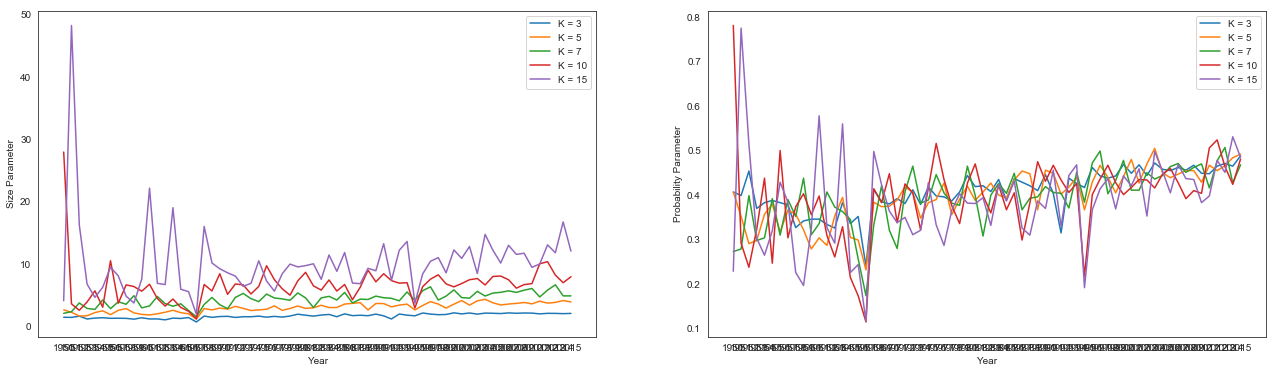

In [58]:
X = list(range(1950, 2016))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(22, 6))

K = 3
size_variations3, prob_variations3, means3, medians3, maxidxs3 = get_parameter_variations(K)
plot(X, size_variations3, ax1, label="K = 3")
plot(X, prob_variations3, ax2, label="K = 3")

K = 5
size_variations5, prob_variations5, means5, medians5, maxidxs5 = get_parameter_variations(K)    
plot(X, size_variations5, ax1, label="K = 5")
plot(X, prob_variations5, ax2, label="K = 5")

K = 7
size_variations7, prob_variations7, means7, medians7, maxidxs7 = get_parameter_variations(K)    
plot(X, size_variations7, ax1, label="K = 7")
plot(X, prob_variations7, ax2, label="K = 7")

K = 10
size_variations10, prob_variations10, means10, medians10, maxidxs10 = get_parameter_variations(K)    
plot(X, size_variations10, ax1, label="K = 10")
plot(X, prob_variations10, ax2, label="K = 10")

K = 15
size_variations15, prob_variations15, means15, medians15, maxidxs15 = get_parameter_variations(K)    
plot(X, size_variations15, ax1, label="K = 15", xlabel="Year", ylabel="Size Parameter")
plot(X, prob_variations15, ax2, label="K = 15", xlabel="Year", ylabel="Probability Parameter")

ax1.legend()
ax2.legend()

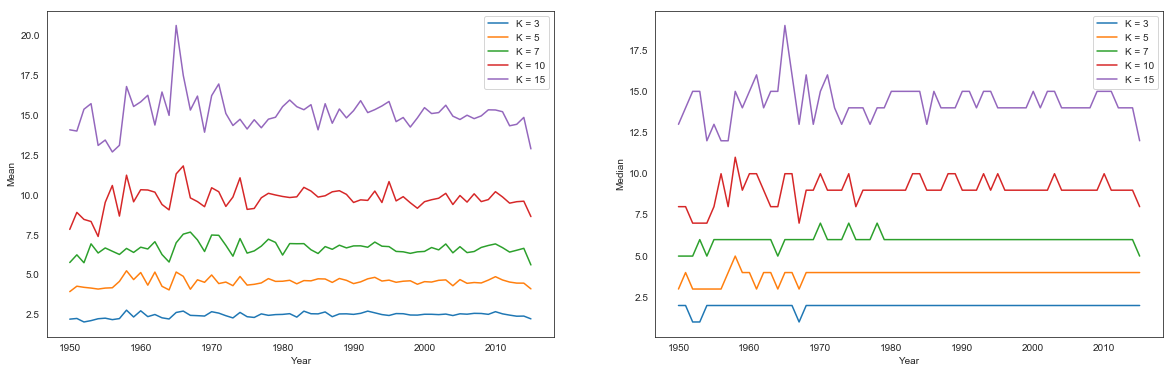

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

plot(X, means3, ax1, label="K = 3")
plot(X, medians3, ax2, label="K = 3")

plot(X, means5, ax1, label="K = 5")
plot(X, medians5, ax2, label="K = 5")

plot(X, means7, ax1, label="K = 7")
plot(X, medians7, ax2, label="K = 7")

plot(X, means10, ax1, label="K = 10")
plot(X, medians10, ax2, label="K = 10")

plot(X, means15, ax1, label="K = 15", xlabel="Year", ylabel="Mean")
plot(X, medians15, ax2, label="K = 15", xlabel="Year", ylabel="Median")

ax1.legend()
ax2.legend()

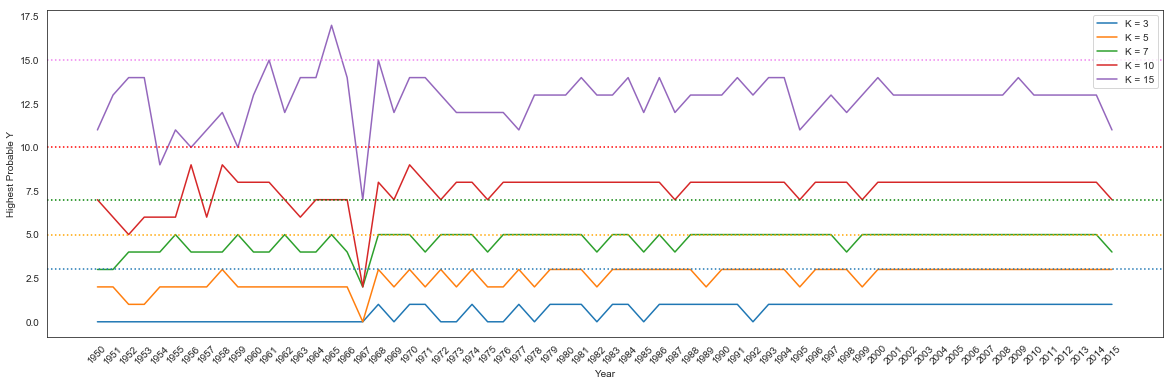

In [65]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(20, 6))

plot(X, maxidxs3, ax1, label="K = 3")
plot(X, maxidxs5, ax1, label="K = 5")
plot(X, maxidxs7, ax1, label="K = 7")
plot(X, maxidxs10, ax1, label="K = 10")
plot(X, maxidxs15, ax1, label="K = 15", xlabel="Year", ylabel="Highest Probable Y")

ax1.axhline(y=3, linestyle=":")
ax1.axhline(y=5, color="orange", linestyle=":")
ax1.axhline(y=7, color="green", linestyle=":")
ax1.axhline(y=10, color="red", linestyle=":")
ax1.axhline(y=15, color="violet", linestyle=":")


ax1.legend()

__Check if the amplitudes are correct__

Optimization terminated successfully.
         Current function value: 3.687930
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


<Figure size 1296x720 with 0 Axes>

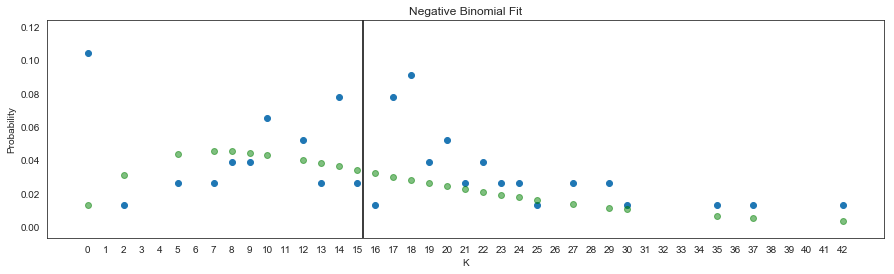

In [66]:
def get_negative_binomial_fit(change_in_values, X):
    
    loglike_method = 'nb2'  # or use 'nb2'
    model = NegativeBinomial(change_in_values, np.ones_like(change_in_values))
    binomial_result = model.fit()
    mu = np.exp(binomial_result.params[0])   
    alpha = binomial_result.params[1]

    if loglike_method == 'nb1':
        Q = 1
    elif loglike_method == 'nb2':    
        Q = 0
    size = 1. / alpha * mu**Q
    prob = size / (size + mu)
    dist_est = nbinom(size, prob)
    
    return dist_est, [dist_est.pmf(k) for k in sorted(X)]    


def plot(X_,Y_, ax=None, title="", xlabel="", ylabel="", dist=None, **kwargs):

    ax = ax or plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(min(X_), max(X_)+1, 1.0))

    if dist:
        ax.axvline(dist.mean(), color="black")
    return ax.scatter(X_,Y_, **kwargs)

N = 67
K = 15

f = plt.figure(figsize=(18, 10))
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 4))

change_in_values, X, Y = get_word_variations(N, K)
dist_est, Y_neg_binomial = get_negative_binomial_fit(change_in_values, X)
plot(X,Y, ax1)
plot(sorted(X),Y_neg_binomial, ax1, 
     title="Negative Binomial Fit", 
     xlabel="K", 
     ylabel="Probability", 
     dist = dist_est,
     alpha=0.5,
     color="green")